# Student Name: Yemaneab Abraha Russom

# Title: Recognizing Retinal diseases Retinal Optical Coherence Tomography (OCT) Images                                                                    


## Retinal disease Classification using AML Python

### Installs and Setup

In [128]:
%config Completer.use_jedi = False
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import json
from azureml.core import Workspace, Dataset, Experiment

ws = Workspace.from_config()

# Get the experiment run context
from azureml.core import Run
run = Run.get_context()

In [91]:
!pip install tensorflow-addons==0.8.3

     |████████████████████████████████| 1.0 MB 24.7 MB/s eta 0:00:01


### Usefull libraries

In [2]:
# Keras Libraries used in this task
import keras
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras import regularizers

from keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.metrics import plot_precision_recall_curve

In [27]:
# additional libraries
import os
from glob import glob
!pip install split_folders
import splitfolders

import numpy as np
import seaborn as sns
from PIL import Image
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import pandas as pd


### Download the  Data from Kaggle

#### First download the OCT Retinal Dataset to the local computer

In [7]:
# !pip install opendatasets

In [ ]:
# import opendatasets as od

# od.download("https://www.kaggle.com/paultimothymooney/kermany2018")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: yemanababraha
Your Kaggle Key: ········


100%|██████████| 10.8G/10.8G [02:18<00:00, 84.0MB/s]

### Prepare the OCT retinal images 


### Main datasets

In [23]:
# image directories 
CNV_dir = test + '/CNV/'
DME_dir = test + '/DME/'
Drusen_dir = test + '/DRUSEN/'
normal_dir = test + '/NORMAL/'


In [25]:
# Calculate the number of the images in the dataset
print('Number of CNV in Directory:', len(os.listdir(CNV_dir)))
print('Number of DME in Directory:', len(os.listdir(DME_dir)))
print('Number of Dursen in Directory:', len(os.listdir(Drusen_dir)))
print('Number of Normal in Directory:', len(os.listdir(normal_dir)))

Number of CNV in Directory: 242
Number of DME in Directory: 242
Number of Dursen in Directory: 242
Number of Normal in Directory: 242


### Show Dataset

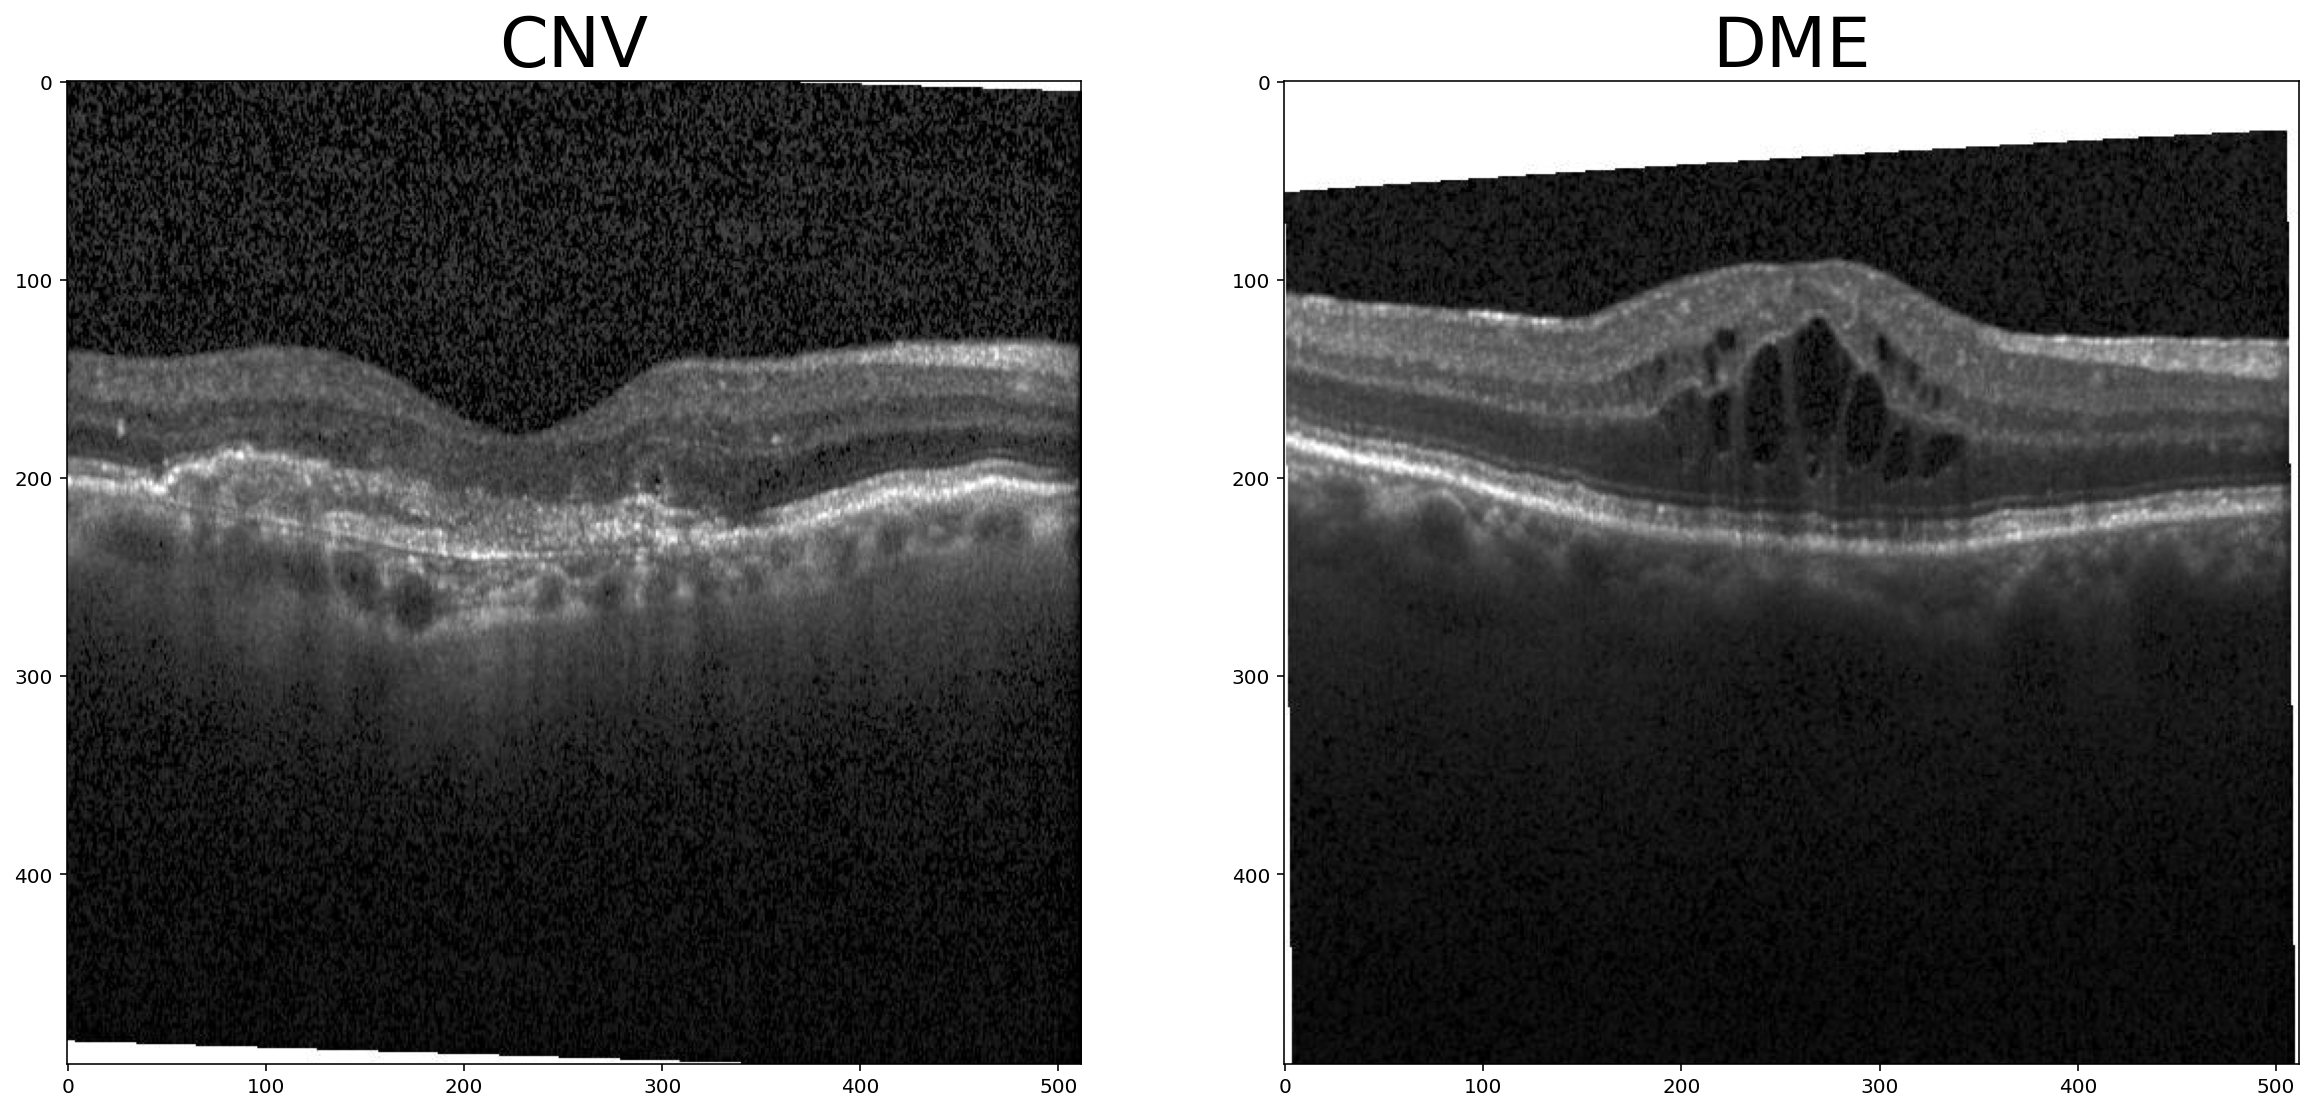

In [32]:
# show the different image labels
CNV_img = Image.open(CNV_dir + os.listdir(CNV_dir)[0])
DME_img = Image.open(DME_dir + os.listdir(DME_dir)[0])




fig = plt.figure(figsize = (20, 20))

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('CNV', fontsize = 35)
plt.imshow(CNV_img, cmap = 'gray')

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('DME', fontsize = 35)
plt.imshow(DME_img, cmap = 'gray')

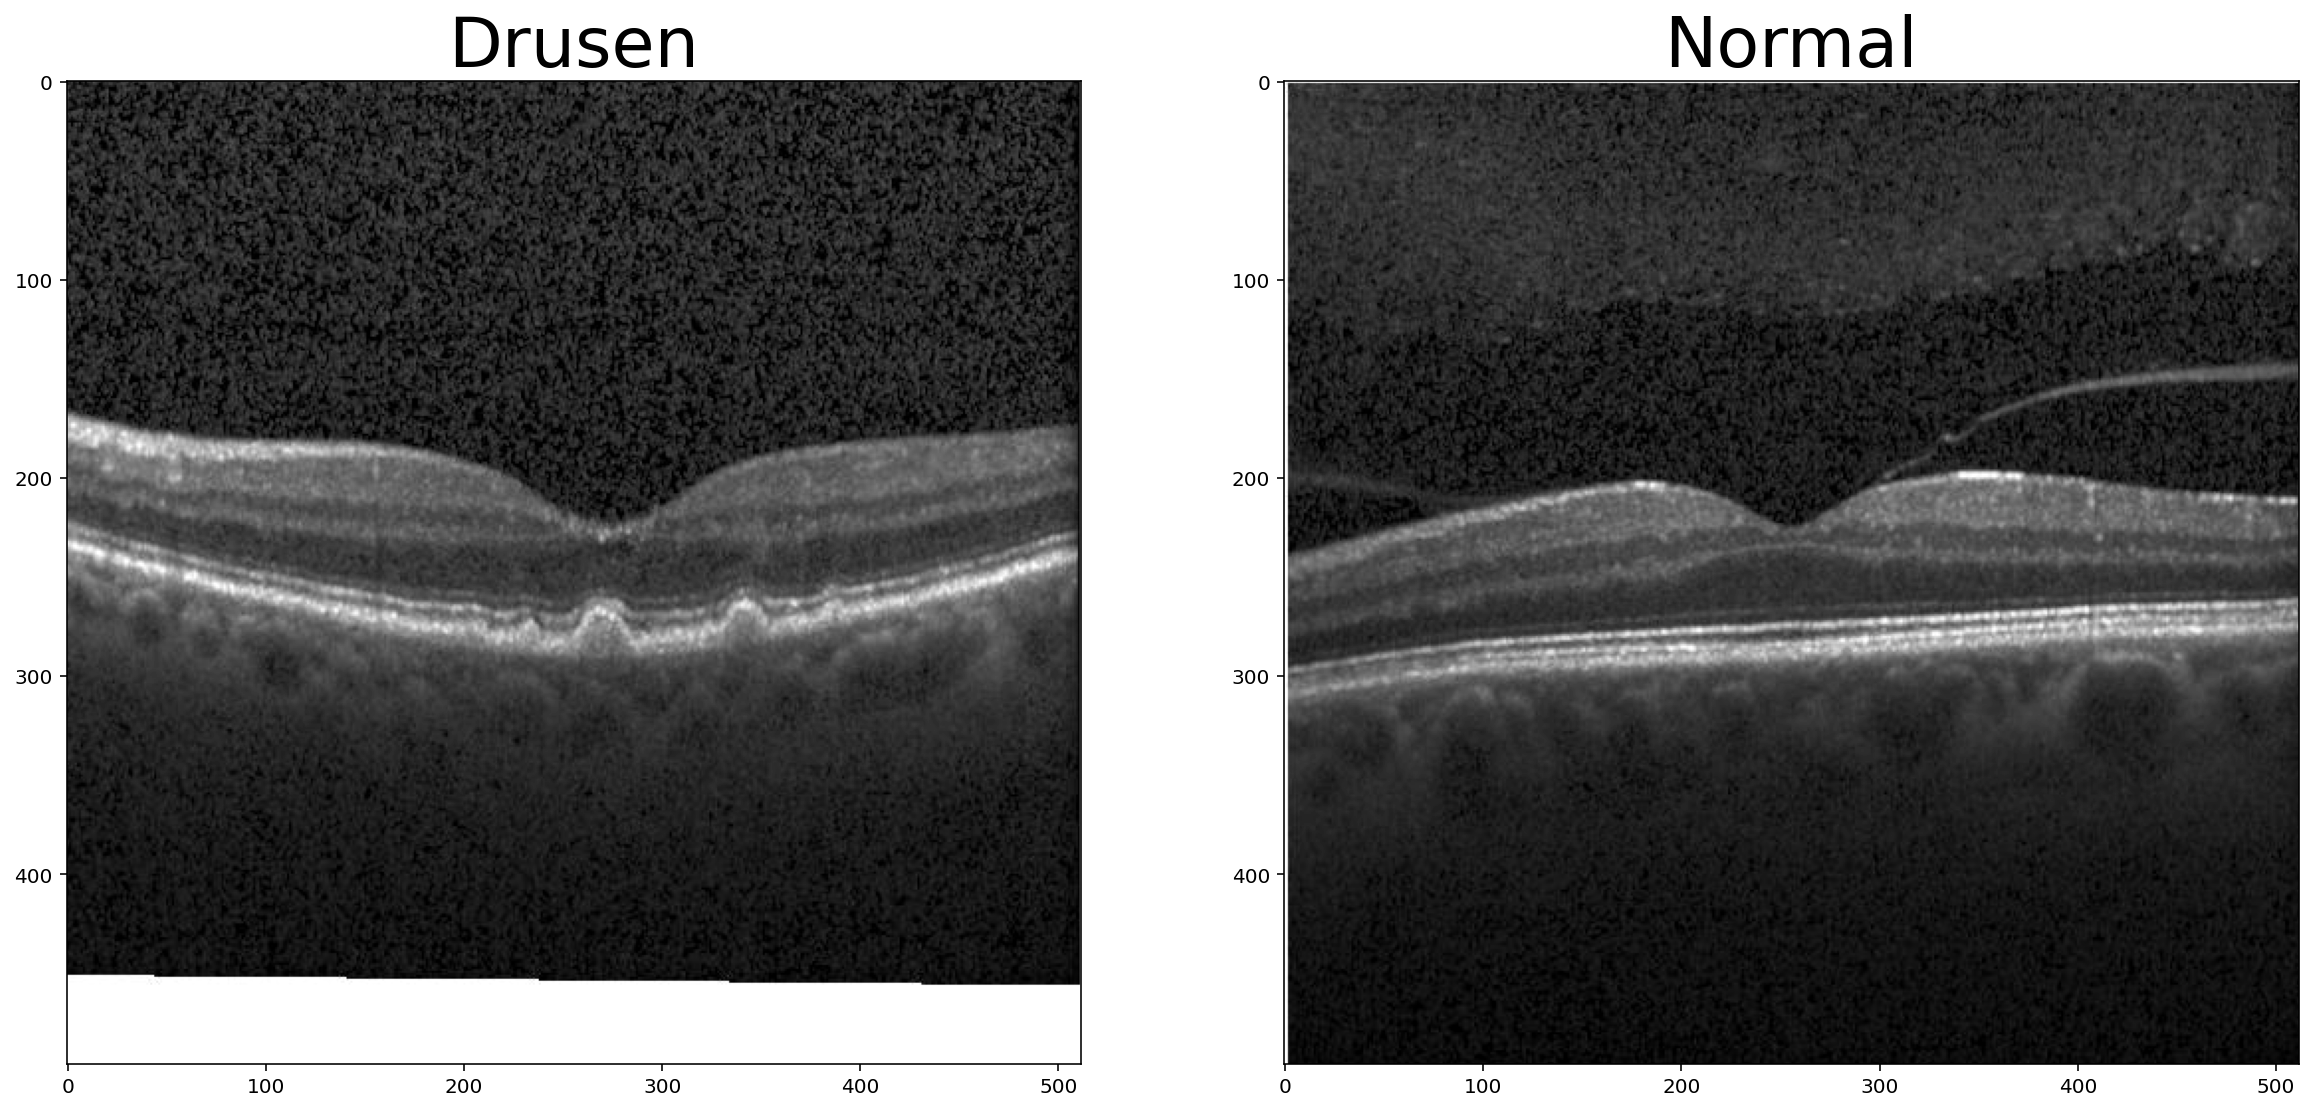

In [33]:
Drusen_img = Image.open(Drusen_dir + os.listdir(Drusen_dir)[0])
normal_img = Image.open(normal_dir + os.listdir(normal_dir)[0])



fig = plt.figure(figsize = (20, 20))

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('Drusen', fontsize = 35)
plt.imshow(Drusen_img, cmap = 'gray')

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('Normal', fontsize = 35)
plt.imshow(normal_img, cmap = 'gray')

### Data Agumentaion

In [130]:
# Setting arguments for data agumentation
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1.0/255,

)

test_datagen = ImageDataGenerator(
     rescale = 1.0/255,

    )

val_datagen = ImageDataGenerator(
    rescale = 1/255,
    )

### Resize the dataset 

In [71]:
train_data = train_datagen.flow_from_directory(train,
                                                 target_size = (224, 224), batch_size = 40, class_mode = 'categorical',shuffle=False)
test_data = test_datagen.flow_from_directory(test, target_size = (224, 224),batch_size = 40,class_mode = 'categorical',shuffle=False)
val_data = val_datagen.flow_from_directory(val, target_size = (224, 224),batch_size = 40, class_mode = 'categorical',shuffle=False)



Found 83484 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


### Show sample the agumented datasets

In [35]:
def showImage(img):
    fig, axes = plt.subplots(1, 5, figsize=(15,15))
    axes = axes.flatten()
    for m, ax in zip(img, axes):
        ax.imshow(m)
    plt.tight_layout()
    plt.show()

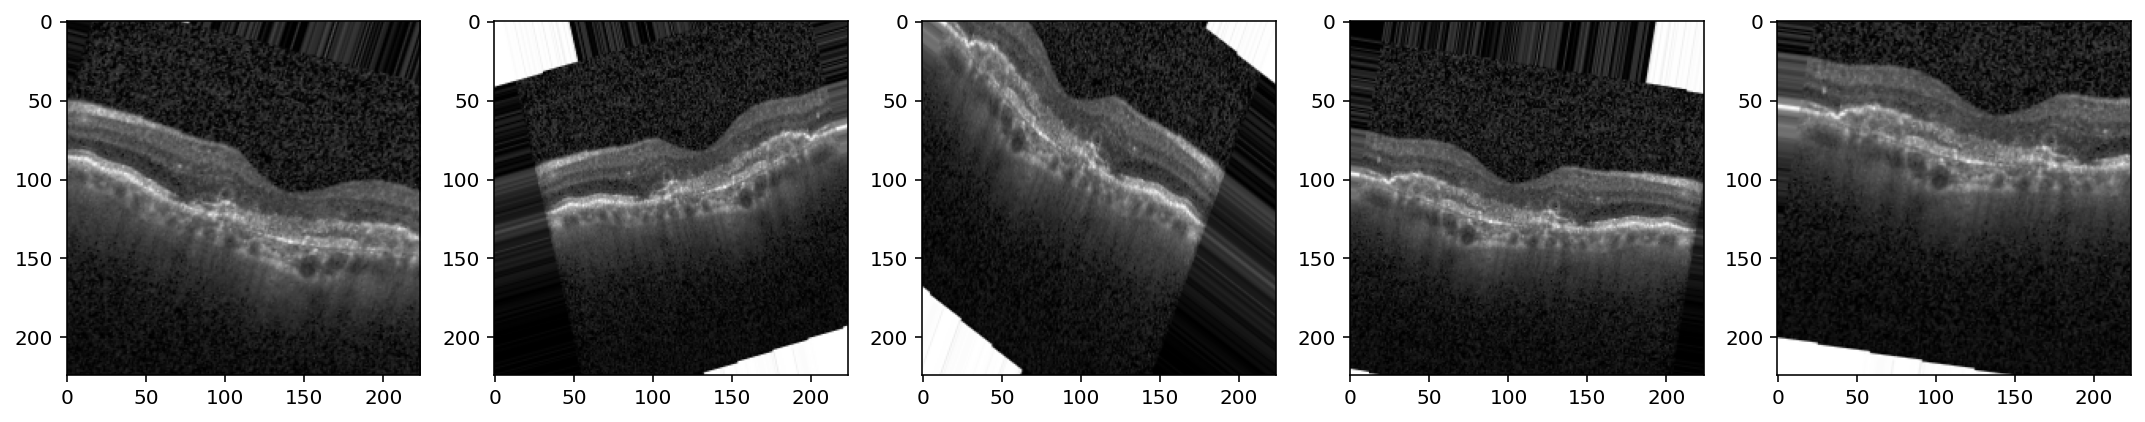

In [36]:
aug_img = [train_data[0][0][0] for i in range(5)]
showImage(aug_img)

### Build the Proposed Model

#### Build the base model

In [72]:
img_size = [224, 224]

# # download the VGG model
transfer_vgg = VGG16(input_shape=img_size + [3], weights='imagenet', include_top=False)

for i in transfer_vgg.layers:
  i.trainable = False

### Build newly created models

In [87]:
model_vgg16 = tf.keras.models.Sequential([
    
    transfer_vgg,
    tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = 'same'),
    tf.keras.layers.PReLU(alpha_initializer='zeros'),# modifying final layers of VGG-19
    tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = 'same'),
    tf.keras.layers.PReLU(alpha_initializer='zeros'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100),
    tf.keras.layers.PReLU(alpha_initializer='zeros'),
    tf.keras.layers.Dense(4, activation = 'softmax')
])


### create Accuracy metrics

In [93]:
import tensorflow_addons as tfa
mtrcs = ['accuracy',
                tf.keras.metrics.AUC(),
                tfa.metrics.CohenKappa(num_classes = 4),
                tfa.metrics.F1Score(num_classes = 4),
                tf.keras.metrics.Precision(), 
                tf.keras.metrics.Recall()]

### Compile the model

In [94]:
model_vgg16.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = mtrcs)
model_vgg16.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         589952    
_________________________________________________________________
p_re_lu_3 (PReLU)            (None, 7, 7, 128)         6272      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          73792     
_________________________________________________________________
p_re_lu_4 (PReLU)            (None, 7, 7, 64)          3136      
_________________________________________________________________
flatten_16 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 100)              

### Train the proposed Model

In [113]:

x = ModelCheckpoint( filepath='vgg16_new_model.9017',
                               verbose=2, save_best_only=True)
y = EarlyStopping(monitor='val_acc',
                           patience=6,
                           mode='max')

call_backs = [x,y]

starting_time = datetime.now()

history_vgg16 = model_vgg16.fit(
    train_data,
    steps_per_epoch = (83484/500),
    epochs =10,
    callbacks=call_backs,
    validation_data = val_data,
    validation_steps = (32/16),
    max_queue_size=100,
    workers = 4 ,
    use_multiprocessing=True,
    verbose = 1)

time_elapsed = datetime.now() - starting_time

print("The time elapsed to train the model is : ", time_elapsed)


Epoch 1/10
166/166 [==============================] - 1024s 6s/step - loss: 0.1090 - accuracy: 0.9621 - auc_1: 0.9978 - cohen_kappa: 0.9494 - f1_score: 0.9620 - precision: 0.9661 - recall: 0.9591 - val_loss: 0.0817 - val_accuracy: 0.9688 - val_auc_1: 0.9990 - val_cohen_kappa: 0.9583 - val_f1_score: 0.9686 - val_precision: 0.9688 - val_recall: 0.9688

Epoch 00001: val_loss improved from inf to 0.08172, saving model to vgg16_new_model.9017
INFO:tensorflow:Assets written to: vgg16_new_model.9017/assets
Epoch 2/10
166/166 [==============================] - 1027s 6s/step - loss: 0.0122 - accuracy: 0.9981 - auc_1: 1.0000 - cohen_kappa: 0.9975 - f1_score: 0.9981 - precision: 0.9981 - recall: 0.9975 - val_loss: 0.1067 - val_accuracy: 0.9688 - val_auc_1: 0.9990 - val_cohen_kappa: 0.9583 - val_f1_score: 0.9686 - val_precision: 0.9688 - val_recall: 0.9688

Epoch 00002: val_loss did not improve from 0.08172
Epoch 3/10
166/166 [==============================] - 1037s 6s/step - loss: 0.0016 - accura

### Display the accuracy history

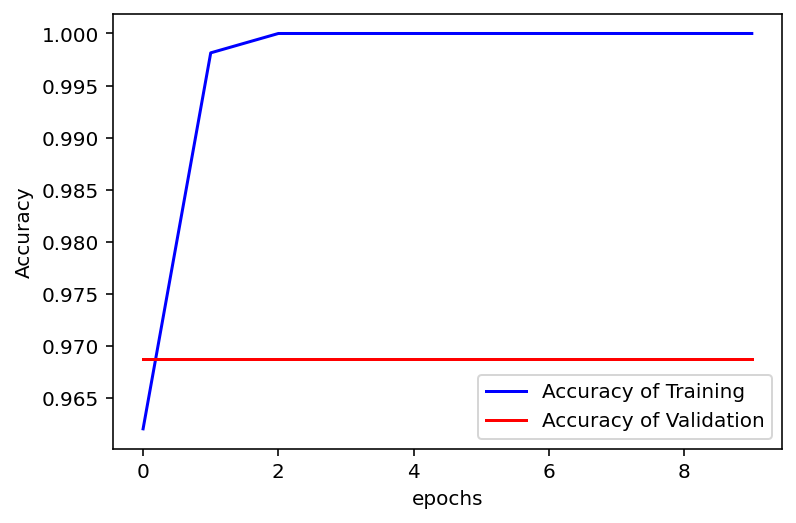

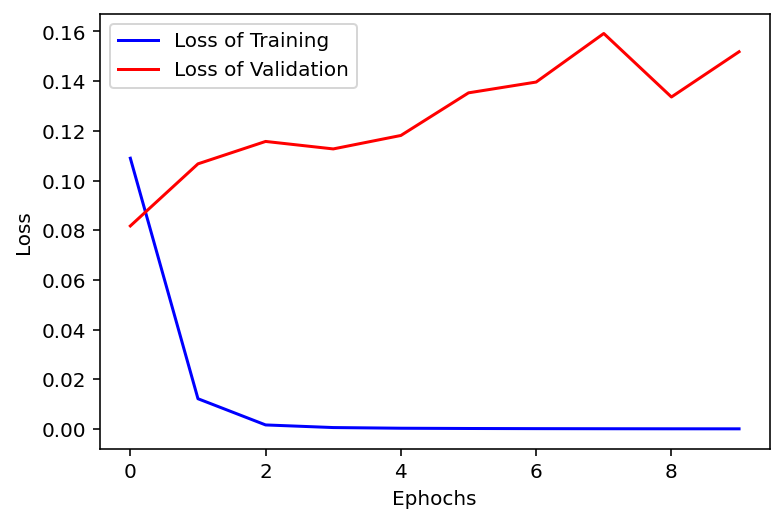

In [114]:
acc = history_vgg16.history['accuracy']
val_acc = history_vgg16.history['val_accuracy']
loss = history_vgg16.history['loss']
val_loss = history_vgg16.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, "b", label="Accuracy of Training")
plt.plot(epochs, val_acc, "r", label="Accuracy of Validation")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.show()

plt.plot(epochs, loss, "b", label="Loss of Training")
plt.plot(epochs, val_loss, "r", label="Loss of Validation")
plt.legend()
plt.xlabel("Ephochs")
plt.ylabel("Loss")
plt.show()

### Evaluate the model

In [115]:
test_step_per_epoch = np.math.ceil(test_data.samples / test_data.batch_size)

pred = model_vgg16.predict_generator(test_data, steps = test_step_per_epoch)

pred_classes = np.argmax(pred, axis=1)

In [116]:

act_classes = test_data.classes
labels = list(test_data.class_indices.keys())


In [117]:
import sklearn.metrics
performance = sklearn.metrics.classification_report(act_classes, pred_classes, target_names = labels)
print(performance)


              precision    recall  f1-score   support

         CNV       1.00      1.00      1.00       242
         DME       1.00      1.00      1.00       242
      DRUSEN       1.00      1.00      1.00       242
      NORMAL       1.00      1.00      1.00       242

    accuracy                           1.00       968
   macro avg       1.00      1.00      1.00       968
weighted avg       1.00      1.00      1.00       968



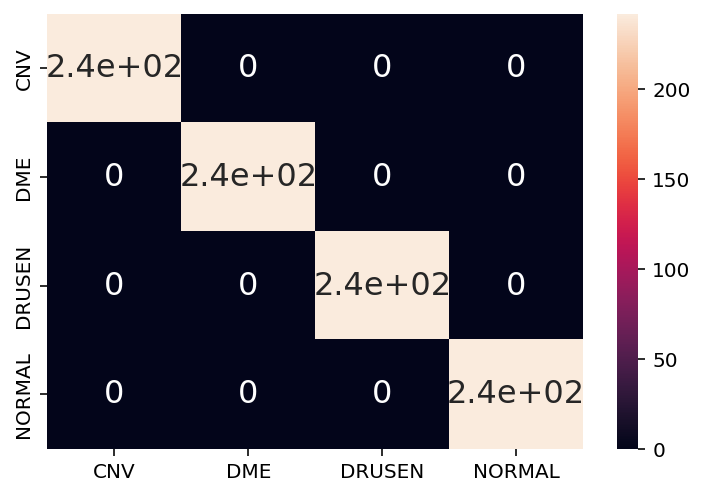

In [122]:
con_matrix = confusion_matrix(act_classes, pred_classes) 
sns.heatmap(con_matrix, annot=True, annot_kws={"size": 16},xticklabels=test_data.class_indices,yticklabels=test_data.class_indices,)


### Register a Model

In [132]:
from azureml.core.model import Model
model = Model.register(model_path="Retinal_model.pkl",
                        model_name="Retinal_model",
                        tags={'area': "Retinal", 'type': "Classification"},
                        description="Classification ML model to classify Retinal diseases",
                        workspace=ws)

Registering model Retinal_model


### Show the registered model

In [135]:
# Show the registered Model

for model in Model.list(ws):
    print(model.name, 'version:', model.version)
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print ('\t',tag_name, ':', tag)
    for prop_name in model.properties:
        prop = model.properties[prop_name]
        print ('\t',prop_name, ':', prop)
    print('\n')

Retinal_model version: 1
	 area : Retinal
	 type : Classification


